### Importovanie potrebných knižníc a nástrojov

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pathlib
import numpy as np
import pandas as pd
import os

from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, classification_report

### Pripojenie Google disku pre načítanie datasetu

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Skopírovanie datasetov a zadefinovanie ciest k nim

In [3]:
TRAIN_DATA_DIR_GDRIVE = '/content/drive/MyDrive/Colab Notebooks/train_8vs8'
VALIDATION_DATA_DIR_GDRIVE = '/content/drive/MyDrive/Colab Notebooks/validation_8vs8'
TEST_DATA_DIR_GDRIVE = '/content/drive/MyDrive/Colab Notebooks/test_8vs8'

In [4]:
!cp -r "$TRAIN_DATA_DIR_GDRIVE" .
!cp -r "$VALIDATION_DATA_DIR_GDRIVE" .
!cp -r "$TEST_DATA_DIR_GDRIVE" .

In [5]:
TRAIN_DATA_DIR = './train_8vs8'
VALIDATION_DATA_DIR = './validation_8vs8'
TEST_DATA_DIR = './test_8vs8'

TRAIN_DATASET_PATH = pathlib.Path(TRAIN_DATA_DIR)
VALIDATION_DATASET_PATH = pathlib.Path(VALIDATION_DATA_DIR)
TEST_DATASET_PATH = pathlib.Path(TEST_DATA_DIR)

### Vytvorenie ImageDataGenerator-ov, ktoré slúžia pre načítanie, predspracovanie a augmentáciu obrázkov

In [6]:
train_validation_datagen = ImageDataGenerator(
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True)

test_datagen = ImageDataGenerator()

In [7]:
BATCH_SIZE = 64
IMG_SIZE = (240, 240)

train_dataset = train_validation_datagen.flow_from_directory(
    TRAIN_DATASET_PATH, 
    target_size=IMG_SIZE, 
    class_mode='categorical', 
    batch_size=BATCH_SIZE, 
    shuffle=True
)

validation_dataset = test_datagen.flow_from_directory(
    VALIDATION_DATASET_PATH, 
    target_size=IMG_SIZE, 
    class_mode='categorical', 
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataset = test_datagen.flow_from_directory(
      TEST_DATASET_PATH, 
      target_size=IMG_SIZE, 
      class_mode='categorical', 
      batch_size=BATCH_SIZE, 
      shuffle=False
)

Found 2876 images belonging to 16 classes.
Found 363 images belonging to 16 classes.
Found 363 images belonging to 16 classes.


### Vykreslenie augmentovaných trenovacích obrázkov

In [ ]:
plot_dataset = train_validation_datagen.flow_from_directory(
    TRAIN_DATASET_PATH, 
    target_size=IMG_SIZE, 
    class_mode='categorical', 
    batch_size=1,
    shuffle=True
)

fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(50,50))

for i in range(5):
  image = next(plot_dataset)[0].astype('uint8')
  image = np.squeeze(image)

  ax[i].imshow(image)
  ax[i].axis('off')

### Model

*   EfficientNetB1, ktorý je trénovaný pomocou transfer learningu
*   Modelu boli odobraté posledné vrstvy pre klasifikovanie 1000 tried a bola mu pridaná Flatten vrstva a Dense vrstva so softmax funkciou pre klasifikovanie 16 tried húb



In [ ]:
b1 = EfficientNetB1(input_shape=(240, 240, 3), weights='imagenet', include_top=False, classifier_activation="softmax") 

27033600/27018416 [==============================] - 0s 0us/step


In [ ]:
for layer in b1.layers:
    layer.trainable = False

In [ ]:
x = Flatten()(b1.output)

In [ ]:
prediction = Dense(16, activation='softmax')(x)

model = Model(inputs=b1.input, outputs=prediction)

In [ ]:
LAYERS_COUNT = len(model.layers)

print('Count of model layers: ', LAYERS_COUNT)

Count of model layers:  341


In [ ]:
model.layers

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
model.compile(
  loss='categorical_crossentropy',
  optimizer=tf.keras.optimizers.Adam(0.0003),
  metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 240, 240, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 240, 240, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 241, 241, 3)  0           ['normalization[0][0]']      

In [ ]:
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)

In [ ]:
history = model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=20,
  callbacks=[early_stop],
  batch_size=BATCH_SIZE)

Epoch 1/20
45/45 [==============================] - 104s 2s/step - loss: 1.3347 - accuracy: 0.6558 - val_loss: 0.4221 - val_accuracy: 0.8705
Epoch 2/20
45/45 [==============================] - 92s 2s/step - loss: 0.5021 - accuracy: 0.8564 - val_loss: 0.3500 - val_accuracy: 0.8871
Epoch 3/20
45/45 [==============================] - 92s 2s/step - loss: 0.4061 - accuracy: 0.8887 - val_loss: 0.2514 - val_accuracy: 0.9284
Epoch 4/20
45/45 [==============================] - 94s 2s/step - loss: 0.3333 - accuracy: 0.9152 - val_loss: 0.2727 - val_accuracy: 0.9091
Epoch 5/20
45/45 [==============================] - 93s 2s/step - loss: 0.3092 - accuracy: 0.9190 - val_loss: 0.3828 - val_accuracy: 0.9036
Epoch 6/20
45/45 [==============================] - 93s 2s/step - loss: 0.3059 - accuracy: 0.9197 - val_loss: 0.2441 - val_accuracy: 0.9201
Epoch 7/20
45/45 [==============================] - 93s 2s/step - loss: 0.2702 - accuracy: 0.9353 - val_loss: 0.2571 - val_accuracy: 0.9311
Epoch 8/20
45/45 [=

# Vykreslenie grafov hodnôt presnosti a stratovej funkcie

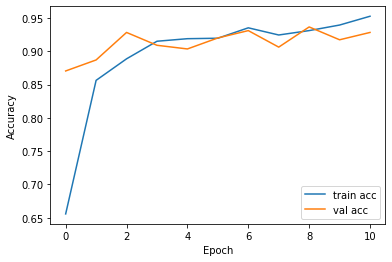

In [ ]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

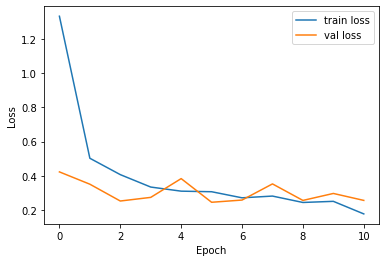

In [ ]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluácia vytrénovaného modelu

In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset,batch_size=BATCH_SIZE)

6/6 [==============================] - 6s 843ms/step - loss: 0.1912 - accuracy: 0.9477


In [ ]:
print("Testovacia loss {0:.2f}, Testovacia accuracy {1:.2f}%".format(test_loss, test_accuracy * 100))

Testovacia loss 0.19, Testovacia accuracy 94.77%


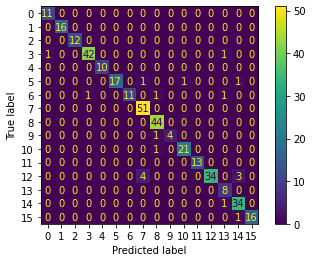

In [ ]:
Y_true_classes = test_dataset.classes
Y_predict = model.predict(test_dataset)

Y_pred_classes = np.argmax(Y_predict, axis=1)

CONFUSION_MATRIX = confusion_matrix(Y_true_classes, Y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=CONFUSION_MATRIX)

disp = disp.plot()

In [ ]:
print(classification_report(Y_true_classes, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        11
           1       1.00      1.00      1.00        16
           2       1.00      1.00      1.00        12
           3       0.98      0.95      0.97        44
           4       1.00      1.00      1.00        10
           5       1.00      0.85      0.92        20
           6       1.00      0.79      0.88        14
           7       0.91      1.00      0.95        51
           8       0.94      1.00      0.97        44
           9       1.00      0.80      0.89         5
          10       0.95      0.95      0.95        22
          11       1.00      1.00      1.00        13
          12       1.00      0.83      0.91        41
          13       0.73      1.00      0.84         8
          14       0.87      0.97      0.92        35
          15       1.00      0.94      0.97        17

    accuracy                           0.95       363
   macro avg       0.96   

# Uloženie modelu

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/models/model_EfficientNetB1_acc96_valacc92_testacc95.h5') 

# Načítanie uloženého modelu

In [ ]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/models/model_EfficientNetB1_acc96_valacc92_testacc95.h5')

In [ ]:
loaded_model.summary()

In [ ]:
loss, acc = loaded_model.evaluate(test_dataset)
print("Načítaný model, loss {0:.2f}, accuracy {1:.2f}%".format(loss, acc * 100))

6/6 [==============================] - 19s 985ms/step - loss: 0.1912 - accuracy: 0.9477
Načítaný model, loss 0.19, accuracy 94.77%
